In [2]:
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as plt
import Price_Models as pm
import Data
import ML

n = 100 #Sample size
iterations = 100 # max tries

# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 256
est_price_path = './Data/tmp.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,14)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

# Importing data
df = Data.GetData(start_date, df_end, trade_days, Update)
df = df.sample(n)  #Reduce data size for testing purposes
r = 0.0553
# Uncomment to select only one stock
# stock = '^SPX'
# df = df[df['symbol'] == stock]

def compute_errors(dsigma, r):
    LSMC_est_price = [] 
    BIN_est_price = [] 
    BS_est_price = [] 
    MJD_est_price = []

    
    for i in range(len(df)):
        S0 = df.iloc[i].S0       # Sets S0
        K = df.iloc[i].strike
        T = df.iloc[i].maturity / 365
        sigma = df.iloc[i].sigma + dsigma
        type = df.iloc[i].optionType

        if df.iloc[i].method == 'A':
            computed_price_LSMC = pm.LSMC(S0, K, T, sigma, r, type)
            computed_price_BIN = pm.BinomialTree(S0, K, T, sigma, r, type)
            computed_price_BS = np.nan
            computed_price_MJD = np.nan
        elif df.iloc[i].method == 'E':
            computed_price_LSMC = np.nan
            computed_price_BIN = np.nan     
            computed_price_BS = pm.BS(S0, K, T, sigma, r, type)
            computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type)
        else:
            raise Exception('Unexpected option method')

        LSMC_est_price.append(computed_price_LSMC)
        BIN_est_price.append(computed_price_BIN)
        BS_est_price.append(computed_price_BS)
        MJD_est_price.append(computed_price_MJD)

    LSMC_perc_error = (df.lastPrice - LSMC_est_price)/df.lastPrice
    BIN_perc_error = (df.lastPrice - BIN_est_price)/df.lastPrice
    BS_perc_error = (df.lastPrice - BS_est_price)/df.lastPrice
    MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice

    averageLSMC = np.sqrt(np.mean((LSMC_perc_error)**2))
    averageBIN = np.sqrt(np.mean((BIN_perc_error)**2))
    averageBS = np.sqrt(np.mean((BS_perc_error)**2))
    averageMJD = np.sqrt(np.mean((MJD_perc_error)**2))

    return averageLSMC, averageBIN, averageBS, averageMJD

def testvalues():
    r = 0.05 # Starting r
    dsigma = 0 #Starting delta sigma
    errors = compute_errors(dsigma, r)
    df_errors_r = pd.DataFrame({'dsigma': dsigma, 'r': r, 'LSMCerror' : errors[0], 'BINerror' : errors [1], 'BSerror' : errors[2], 'MJDerror' : errors[3]},index=[0])

    for i in tqdm(range(iterations)):
        r += 0.03*(np.random.rand() - 0.5)
        r = abs(r)
        errors = compute_errors(dsigma, r)
        df_errors_r.loc[i+1] = [dsigma,r,errors[0],errors[1], errors[2], errors[3]]

    r = 0.05 # Starting r
    dsigma = -0.125 #Starting delta sigma
    errors = compute_errors(dsigma, r)
    df_errors_sigma = pd.DataFrame({'dsigma': dsigma, 'r': r, 'LSMCerror' : errors[0], 'BINerror' : errors [1], 'BSerror' : errors[2], 'MJDerror' : errors[3]},index=[0])

    for i in tqdm(range(iterations)):
        dsigma += 0.01*(np.random.randn())
        errors = compute_errors(dsigma, r)
        df_errors_sigma.loc[i+1] = [dsigma,r,errors[0],errors[1], errors[2], errors[3]]

    return df_errors_r, df_errors_sigma

values = testvalues()

values_r = pd.DataFrame(values[0]) 
values_sigma = pd.DataFrame(values[1])

values_r.to_csv('./Data/calibration_r.csv')
values_sigma.to_csv('./Data/calibration_sigma.csv')

100%|██████████| 100/100 [07:24<00:00,  4.44s/it]


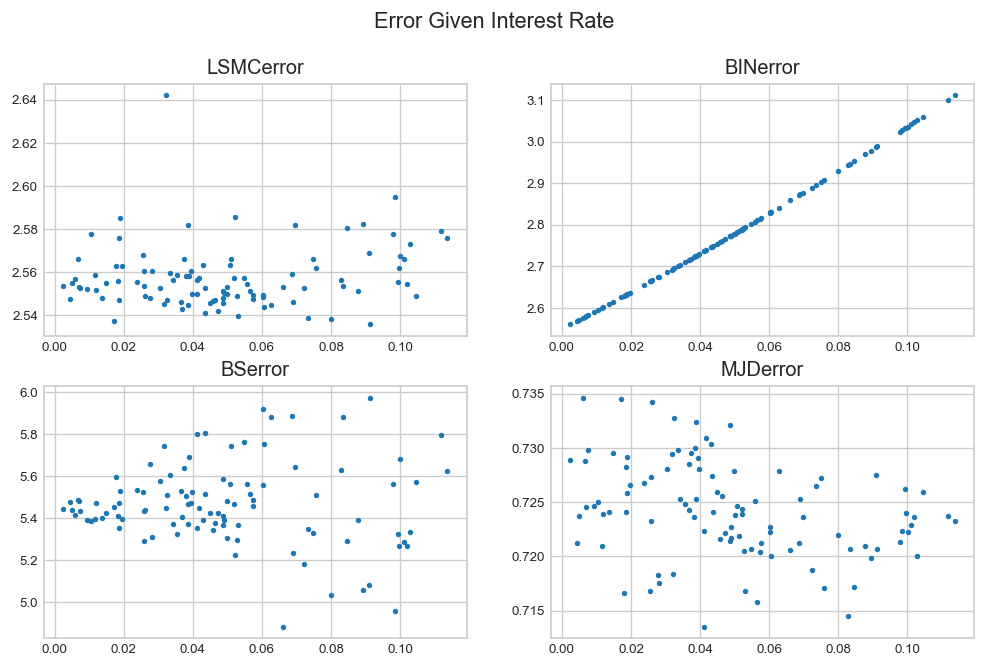

<Figure size 640x480 with 0 Axes>

In [9]:
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid") 
fig, axes = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(10,6), dpi = 120)
tmp_r = values_r.drop(columns=['r', 'dsigma'])
for i, ax in enumerate(axes.flatten()):
    data = tmp_r[tmp_r.columns[i]]
    ax.scatter(values_r.r, data, s = 5)
    # Decorations
    ax.set_title(tmp_r.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.tick_params(labelsize=8)
plt.pyplot.suptitle('Error Given Interest Rate', fontsize = 13)
plt.pyplot.show()
plt.pyplot.savefig('err_int_rate.png')


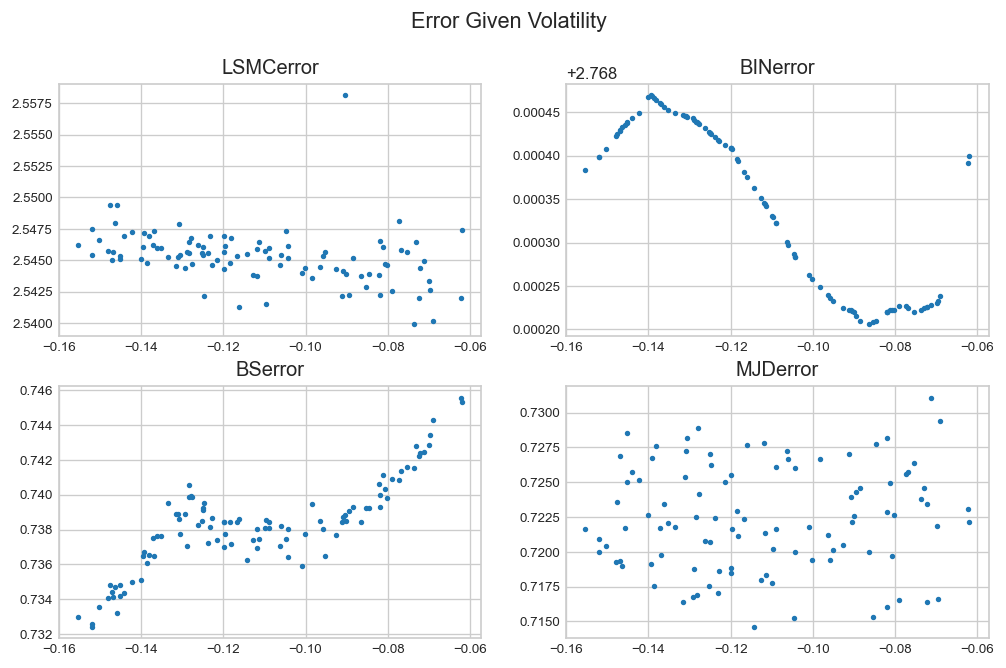

<Figure size 640x480 with 0 Axes>

In [11]:
fig, axes = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(10,6), dpi = 120)
tmp_sigma = values_sigma.drop(columns=['r', 'dsigma'])

for i, ax in enumerate(axes.flatten()):
    data = tmp_sigma[tmp_sigma.columns[i]]
    ax.scatter(values_sigma.dsigma, data, s = 5)
    # Decorations
    ax.set_title(tmp_sigma.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.tick_params(labelsize=8)
plt.pyplot.suptitle('Error Given Volatility', fontsize = 13)
plt.pyplot.show()
plt.pyplot.savefig('err_volatility.png')